In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm
from datetime import datetime

In [4]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

original_train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
original_val_ds = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(original_train_ds, batch_size=24, shuffle=True)
val_loader = DataLoader(original_val_ds, batch_size=24, shuffle=True)

# Destroying the image: The Forward Process

To "drown" the image, we mix the current image with a tiny bit of Gaussian noise at each step $t$. 

### The Single Step (Recursive)
$$x_{t} = \sqrt{1 - \beta_t} x_{t-1} + \sqrt{\beta_t} \epsilon$$

* We use **Square Roots** because of the Variance Rule: $Var(aX + b\epsilon) = a^2 Var(X) + b^2 Var(\epsilon)$.
* By using $a = \sqrt{1-\beta}$ and $b = \sqrt{\beta}$, the new variance is $(\sqrt{1-\beta})^2 + (\sqrt{\beta})^2 = (1-\beta) + \beta = 1$.
* This ensures the "volume" of the pixels stays constant at $1.0$ and never explodes or melts.

### The "Alpha" Shortcut (The Teleporter)
Instead of looping 1,000 times, we define $\alpha_t = 1 - \beta_t$. Expanding the recursion for two steps ($x_2$) looks like this:

$$x_2 = \sqrt{\alpha_2 \alpha_1} x_0 + \sqrt{1 - \alpha_2 \alpha_1} \bar{\epsilon}$$

*Note: In the expansion, the individual noise terms $\epsilon_1$ and $\epsilon_2$ merge into a single cumulative noise $\bar{\epsilon}$ because the sum of two Gaussians is still a Gaussian.*

### The Final Closed-Form Formula
For any timestep $t$, we can jump straight from the original image $x_0$ to the noisy image $x_t$ using:
$$x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon$$

Where $\bar{\alpha}_t$ is the **cumulative product** of all alphas up to that point ($\prod_{i=1}^{t} \alpha_i$).

Label: 5
std at 100: 0.3744286596775055
std at 100: 0.3755243718624115
std at 200: 0.5057512521743774
std at 100: 0.37531086802482605
std at 200: 0.5239212512969971
std at 300: 0.6901200413703918
std at 400: 0.7975993156433105
std at 500: 0.8674205541610718


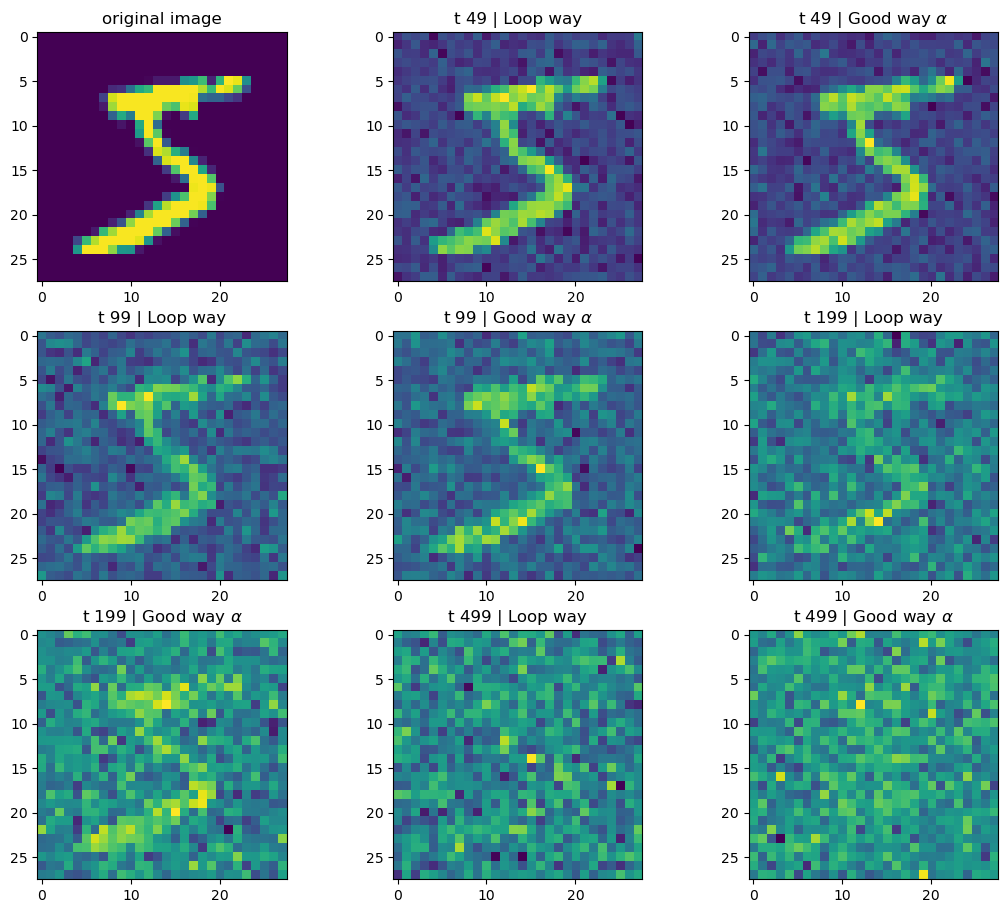

In [5]:
img, label = original_train_ds[0]
img = img[0]

plt.figure(figsize=(13, 11))
plt.subplot(331)
plt.imshow(img)
plt.title("original image")
print(f"Label: {label}")

T = 1000
betas = torch.linspace(0, 0.01, T)
alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)


last_i = 2
for max_t in [50, 100, 200, 500]:
    noised_img_bad = img.clone()
    for t in range(max_t):
        B = betas[t]
        noised_img_bad = torch.sqrt(1 - B) * noised_img_bad + torch.sqrt(B) * torch.randn_like(noised_img_bad)

        if (t + 1) % 100 == 0:
            print(f"std at {t + 1}: {noised_img_bad.std()}")
            
    noised_img_good = torch.sqrt(alphas_cumprod[max_t]) * img + torch.sqrt(1 - alphas_cumprod[max_t]) * torch.randn_like(img)

    plt.subplot(3, 3, last_i)
    plt.imshow(noised_img_bad)
    plt.title(fr"t {t} | Loop way")
    last_i += 1


    plt.subplot(3, 3, last_i)
    plt.imshow(noised_img_good)
    plt.title(fr"t {t} | Good way $\alpha$")
    last_i += 1

Proof why we need teh sqrt

Step       | Exploding Std   | Stable Std     
---------------------------------------------
0          | 0.3125          | 0.3125         
100        | 0.2970          | 0.3688         
200        | 0.2543          | 0.4637         
300        | 0.1997          | 0.6236         
400        | 0.1446          | 0.7417         
500        | 0.0984          | 0.8226         


Text(0.5, 1.0, 'X Stable')

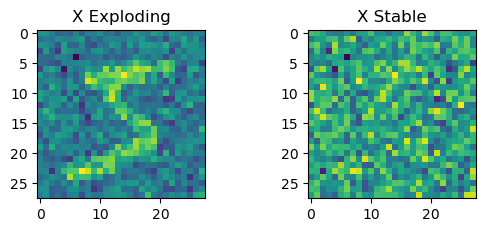

In [6]:
T = 600
x_exploding = img.clone()
# Case B: The Paper's way (Square Roots)
x_stable = img.clone()

print(f"{'Step':<10} | {'Exploding Std':<15} | {'Stable Std':<15}")
print("-" * 45)

for t in range(T):
    beta = betas[t]
    noise = torch.randn_like(img)
    
    x_exploding = (1 - beta) * x_exploding + beta * noise
    
    # CASE B: The Paper (Square roots preserve variance)
    x_stable = torch.sqrt(1 - beta) * x_stable + torch.sqrt(beta) * noise
    
    if t % 100 == 0:
        print(f"{t:<10} | {x_exploding.std():<15.4f} | {x_stable.std():<15.4f}")
        
plt.subplot(221)
plt.imshow(x_exploding)
plt.title("X Exploding")

plt.subplot(222)
plt.imshow(x_stable)
plt.title("X Stable")

# The Reverse Process — Training the "Lifeguard"

The core idea is that we don't ask the model to "draw a cat." We ask it: **"What specific noise was added to this image to make it look this messy?"**

### The Forward Bridge
Recall our "Alpha-bar" jump formula:
$$x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon$$

We train a **U-Net** to look at $x_t$ and predict the noise ($\epsilon$). We call its prediction $\hat{\epsilon}_\theta(x_t, t)$.

### Solving for the Original Image
If the model's guess ($\hat{\epsilon}$) is perfect, we can rearrange the forward formula to "solve" for the clean image:
$$\hat{x}_0 = \frac{1}{\sqrt{\bar{\alpha}_t}} \left( x_t - \sqrt{1 - \bar{\alpha}_t} \hat{\epsilon} \right)$$



### Why $t$ is the "Context Clue":
The model isn't just mimicking `torch.randn()`. It is a detective looking for clues. Passing $t$ tells the model the **Signal-to-Noise Ratio**:

* **Low $t$ (The "Polishing" Phase):** The model knows the noise is quiet. It looks for "dust" and "salt-and-pepper" artifacts to clean up, knowing the underlying shape is already 99% correct.
* **High $t$ (The "Creative" Phase):** The model knows the noise is loud (the image is "burnt"). It ignores the fine details and predicts a noise map that, when removed, leaves behind a **rough global structure** (a silhouette) for the next step to refine.

### Training vs. Inference
* **Training:** We pick a random $t$ for each image in a batch and do a "one-shot" guess of the noise. 
* **Inference (Sampling):** We start with pure noise at $t=T$ and **iteratively** ask the model to predict the noise. We subtract a bit of that noise to move from $t \rightarrow t-1$, slowly "crystallizing" the image out of the static.

5


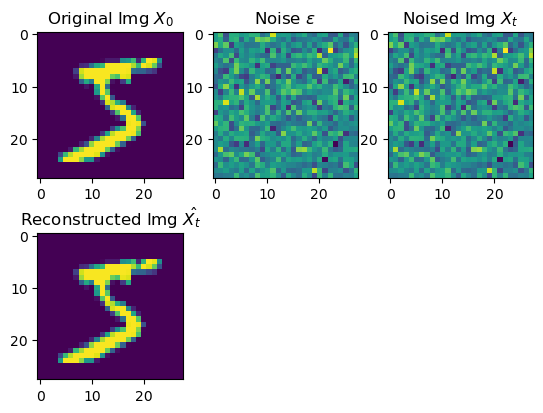

In [29]:
class DiffuserDataset(Dataset):
    def __init__(self, original_ds: Dataset, T=1000, max_noise=0.02):
        self.original_ds = original_ds
        self.T = T
        betas = torch.linspace(0.001, max_noise, T)
        self.alphas_cumprod = torch.cumprod(1 - betas, dim=0)

    def __len__(self):
        return len(self.original_ds)  # type: ignore

    def __getitem__(self, idx):
        x0, label = self.original_ds[idx]
        eps = torch.randn_like(x0)

        t = torch.randint(0, self.T, (1,), dtype=torch.float32)

        alpha_cumprod = self.alphas_cumprod[int(t.item())]  # type: ignore

        xt = torch.sqrt(alpha_cumprod) * x0 + torch.sqrt(1 - alpha_cumprod) * eps

        return {
            "xt": xt,
            "eps": eps,
            "x0": x0,
            "label": label,
            "alpha_cumprod": alpha_cumprod,
            "t": t,
        }


diffuser_train_ds = DiffuserDataset(original_train_ds)
diffuser_val_ds = DiffuserDataset(original_val_ds)

data = diffuser_train_ds[0]

reconstructed_x0 = 1 / torch.sqrt(data["alpha_cumprod"]) * (data["xt"] - torch.sqrt(1 - data["alpha_cumprod"]) * data["eps"])

plt.subplot(231)
plt.imshow(data["x0"][0])
plt.title(r"Original Img $X_0$")

plt.subplot(232)
plt.imshow(data["eps"][0])
plt.title(r"Noise $\epsilon$")

plt.subplot(233)
plt.imshow(data["xt"][0])
plt.title(r"Noised Img $X_t$")

plt.subplot(234)
plt.imshow(reconstructed_x0[0])
plt.title(r"Reconstructed Img $\hat{X_{t}}$")

print(data['label'])

In [30]:
train_loader = DataLoader(diffuser_train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(diffuser_val_ds, batch_size=32, shuffle=True)

In [89]:
img_sz = 28
flatten_size = img_sz * img_sz
p_dropout = 0.3


class DiffuserModel(nn.Module):
    def __init__(self):
        super().__init__()

        feats_in = flatten_size + 64
        self.t_expander = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
        )

        self.encoder = nn.Sequential(
            nn.Linear(feats_in, 256),  # input is 784 + 196 = 980
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            #
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
        )

        self.bottleneck = nn.Linear(128, 128)

        self.decoder = nn.Sequential(
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            #
            nn.Linear(256, flatten_size),
        )

        self.head = nn.Sequential(
            nn.Linear(flatten_size, flatten_size),
            nn.BatchNorm1d(flatten_size),
            nn.ReLU(),
            nn.Linear(flatten_size, flatten_size),
        )

    def forward(self, xt: torch.Tensor, t: torch.Tensor):
        xt = xt.flatten(start_dim=1)
        t_expanded = self.t_expander(t)

        concated = torch.concat((xt, t_expanded), dim=1)

        encoded = self.encoder(concated)
        encoded = self.bottleneck(encoded)
        decoded = self.decoder(encoded)
        
        eps = self.head(decoded + xt)

        return eps


dummy = torch.rand(size=(3, 28, 28))
dummy_t = torch.randint(low=0, high=T, size=(3, 1), dtype=torch.float32)
model = DiffuserModel()
model(dummy, dummy_t)

tensor([[-0.0387,  0.1423,  0.2495,  ..., -0.5114,  0.2758,  0.0592],
        [ 0.3318, -0.8258,  0.1309,  ...,  0.1847, -0.4502, -0.3351],
        [ 0.8209,  0.1444,  0.0946,  ...,  0.0549, -0.1064,  0.2625]],
       grad_fn=<AddmmBackward0>)

In [90]:
run_name = datetime.now().strftime("%Y%m%d-%H%M%S")
writer = SummaryWriter()
writer.add_graph(model, [dummy, dummy_t])
writer.close()

In [91]:
avg_train_losses = []
avg_val_losses = []

In [94]:
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [95]:
epochs = 3
grad_acumm_steps = 40

for epoch in range(epochs):
    avg_train_loss = 0

    model.train()
    train_bar = tqdm(train_loader, desc="Training")
    for i, data in enumerate(train_bar):
        xt, eps, t = data["xt"], data["eps"], data["t"]
        eps_pred = model(xt, t)

        loss = criterion(eps_pred, eps.flatten(start_dim=1))
        avg_train_loss += loss.item()
        loss.backward()

        if (i + 1) % grad_acumm_steps == 0:
            opt.step()
            opt.zero_grad()

        train_bar.set_postfix(loss=avg_train_loss / (i + 1))

    avg_train_loss /= len(train_loader)
    with torch.no_grad():
        avg_val_loss = 0
        model.eval()
        val_bar = tqdm(val_loader, desc="Validation")
        for i, data in enumerate(val_bar):
            xt, eps, t = data["xt"], data["eps"], data["t"]
            eps_pred = model(xt, t)

            loss = criterion(eps_pred, eps.flatten(start_dim=1))
            avg_val_loss += loss.item()

            val_bar.set_postfix(loss=avg_val_loss / (i + 1))

        avg_val_loss /= len(val_loader)
        
    avg_train_losses.append(avg_train_loss)
    avg_val_losses.append(avg_val_loss)
    
    print(f"EPOCH {epoch} | avg train loss {avg_train_loss:.2f} | avg val loss {avg_val_loss:.2f}")

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Validation:   0%|          | 0/313 [00:00<?, ?it/s]

KeyboardInterrupt: 

t: tensor([65.])
ending t: tensor([0.])


Text(0.5, 1.0, 'Reconstructed')

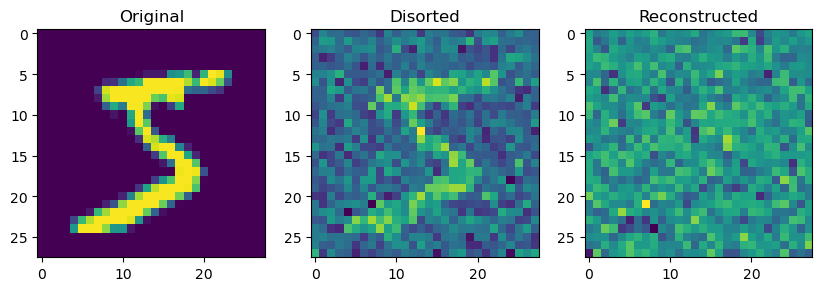

In [140]:
model.eval()
data = diffuser_train_ds[0]
x0 = data['x0']
xt = data['xt']
t = data['t']
eps = data['eps']

betas = torch.linspace(0.001, 0.02, 1000)
alphas_cumprod = torch.cumprod(1 - betas, dim=0)
print(f"t: {t}")

recon = xt
for i in range(100):
    alpha_cp = alphas_cumprod[int(t[0].item())]
    eps_pred = model(xt, t.unsqueeze(0)).view(28, 28)
    recon = 1 / torch.sqrt(alpha_cp) * (recon - torch.sqrt(1 - alpha_cp) * eps_pred)
    t -= 1
    if t <= 0: break
    
print(f"ending t: {t}")


plt.figure(figsize=(10, 8))

plt.subplot(131)
plt.imshow(x0[0])
plt.title("Original")

plt.subplot(132)
plt.imshow(xt[0])
plt.title("Disorted")

plt.subplot(133)
plt.imshow(recon[0].detach().numpy())
plt.title("Reconstructed")